<a href="https://colab.research.google.com/github/ChJazhiel/HPC_II/blob/main/Taller%20GANs/Vainilla_GAN_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vainilla GAN

Objetivo: Generar dígitos escritos a mano con una Red Generativa Adversaria (GAN)

In [ ]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import imageio
import glob
from IPython import display
from tqdm.auto import tqdm # Loading bar

# Importar paquetes de pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Importar paquetes de  torchvision packages
from torchvision import datasets
from torchvision import transforms

## 1. Descargar el conjunto de datos y visualizar imágenes
1. Descargar el conjunto de datos.
2. Exploración del conjunto de datos.

#### Descargar conjunto de datos
Se utiliza el modulo `torchvison.datasets` para descargar el conjunto de datos MNIST.  
Y especificar los siguientes argumentos:
-  `root` Ruta donde se almacena el conjunto de datos.
-  `train` Si *train=True* el conjunto de datos corresponde al conjunto de datos de entrenamiento, *train=False* corresponde a los datos de prueba.
- `download` Descarga el conjunto de datos de internet si no está en la ruta.
- `transform`  Transformaciones en imágenes. Se puede enlazar diferentes transformaciones utilizando `Compose`.

**Consultar**  
- [Datasets](https://pytorch.org/vision/main/datasets.html)  
- [Transforming and augmenting images](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
mnist = datasets.MNIST(root='./data',
                       train=True,
                       download=True,
                       transform = transforms.Compose([transforms.ToTensor(), # Transformar la imagen PIL que está en el formato (Height x Weight x Channel) en el rango [0, 255] a un tensor de forma (Channel x Height x Weight) en el rango [0.0, 1.0]
                                                       transforms.Normalize([0.5],[0.5])])) # Normaliza el tensor con la media y la desviación estándar (output[channel]=(input[channel]-mean[channel])/std[channel])

100%|██████████| 9912422/9912422 [00:00<00:00, 82868344.22it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 11997196.58it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26042081.43it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14049062.51it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Exploración del conjunto de datos

In [ ]:
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [ ]:
# Obtener un elemento del conjunto de datos
img, _ = mnist[0]
print(f"Tamaño de la imagen: {img.shape}") # Channels First  (NCHW)

Tamaño de la imagen: torch.Size([1, 28, 28])


In [ ]:
print(f"Valor máximo del tensor: {img.max()}")
print(f"Valor mínimo del tensor: {img.min()}")

Valor máximo del tensor: 1.0
Valor mínimo del tensor: -1.0


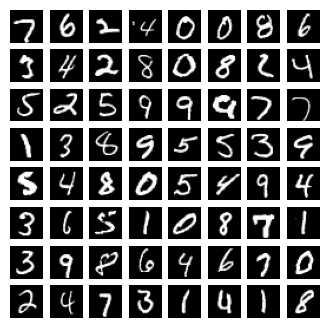

In [ ]:
# Visualizar conjunto de datos
fig = plt.figure(figsize=(4,4))
rows, cols = 8, 8
for i in range(1,rows*cols+1):
    random_idx = random.randint(0, len(mnist))
    img, _ = mnist[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis("off")

## 2. Preparación del Data Loader  
La clase `DataLoader` en PyTorch nos permite cargar e iterar elementos en el conjunto de datos.   
Cada iteración devolverá un lote de imágenes y etiquetas.  
Especificar los siguientes argumentos:
- `dataset` Conjunto de datos que se va a iterar.
- `batch_size` Cantidad de muestras contenidas en un batch.
- `shuffle` Al especificar *shuffle=True* los datos se revuelven después de iterar sobre todos los batches.

**Consultar**  
[Datasets y DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset = mnist,
                               batch_size = BATCH_SIZE,
                               shuffle = True)

In [ ]:
print(f"Número de batches en el train loader: {len(train_dataloader)} batches de {BATCH_SIZE} imágenes cada uno")

Número de batches en el train loader: 938 batches de 64 imágenes cada uno


In [ ]:
# Verificar que hay dentro del DataLoader
train_batches, _ = next(iter(train_dataloader))
print(train_batches.shape)

torch.Size([64, 1, 28, 28])


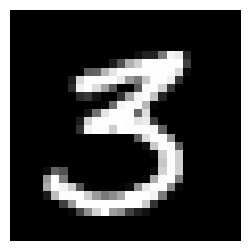

In [ ]:
# Visualizar una imagen en el DataLoader
random_idx = random.randint(0, len(train_batches)-1)
img_batch = train_batches[random_idx]
fig = plt.figure(figsize=(3,3))
plt.imshow(img_batch.squeeze(), cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
# Configuración de CPU o GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## 3. Definir modelo
1. Definir clase Discriminador.
2. Definir clase Generador.
3. Definir función de costo para el discriminador y el generador
4. Definir optimizadores.

### Discriminador
El discriminador es un clasificador binario, cuyo objetivo es clasificar entre datos reales y datos creados por el generador
- **Entrada**: Imagen.
- **Salida**: Probabilidad de que la imagen sea real o falsa.

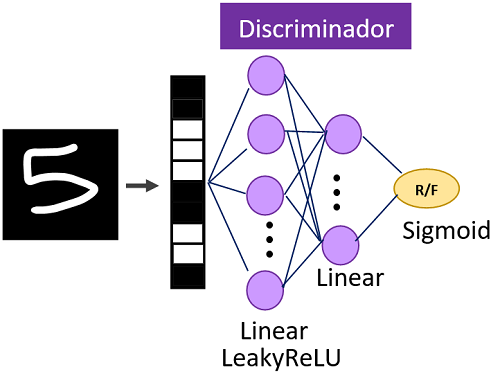

In [ ]:
# Definición de la clase Discriminador
class Discriminator(nn.Module):
    def __init__(self, input_shape, hidden_units):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features = hidden_units,out_features=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [ ]:
# Configurar el modelo con los parámetros de entrada
discriminator = Discriminator(input_shape=784,hidden_units=256)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [ ]:
# Probar discriminador con entrada dummy
dummy_x = torch.rand([1,1,28,28]).to(device)
print(f"Tamaño del vector de entrada del discriminador: {dummy_x.size()}")

dummy_out = discriminator(dummy_x)
print(f"Salida del discriminador: {dummy_out}")

Tamaño del vector de entrada del discriminador: torch.Size([1, 1, 28, 28])
Salida del discriminador: tensor([[0.5135]], device='cuda:0', grad_fn=<SigmoidBackward0>)


### Generador
El Generador genera datos sintéticos que sean indistinguibles de los datos reales para el discriminador.

- **Entrada**: Vector de ruido gaussiano.
- **Salida**: Imagen.  

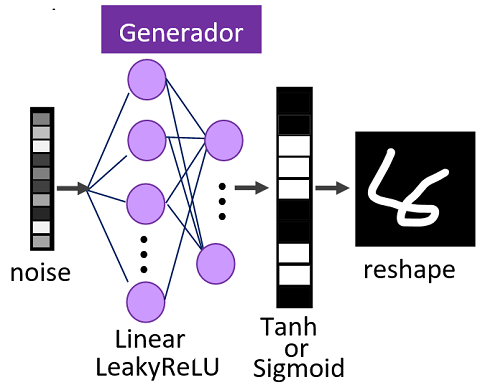

In [ ]:
# Definición de la clase Generador
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_units,output_shape,img_height,img_weigth,channel):
        super().__init__()
        self.img_height = img_height
        self.img_weigth = img_weigth
        self.channel = channel
        self.model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_units),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features = hidden_units,out_features=output_shape),
            nn.Tanh()
        )

    def forward(self,x):
        x = self.model(x)
        x = x.view(-1,self.channel,self.img_height,self.img_weigth) # the size -1 is inferred from other dimensions
        return x

In [ ]:
LATENT_DIM = 100 # Dimensión del vector en el espacio de latencia
IMG_SHAPE = (1,28,28)  # channel,img_height, img_weight

In [ ]:
# Configurar el modelo con los parámetros de entrada
generator = Generator(latent_dim=LATENT_DIM, hidden_units=256,output_shape=784,img_height=IMG_SHAPE[1],img_weigth=IMG_SHAPE[2],channel=IMG_SHAPE[0])
generator.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Tanh()
  )
)

In [ ]:
# Probar generador con entrada dummy
dummy_x = torch.rand([1,100]).to(device)
print(f"Tamaño del vector de entrada del generador: {dummy_x.size()}")

dummy_img = generator(dummy_x).cpu().detach()
print(f"Tamaño de la salida del generador: {dummy_img.shape}")

Tamaño del vector de entrada del generador: torch.Size([1, 100])
Tamaño de la salida del generador: torch.Size([1, 1, 28, 28])


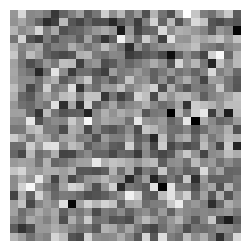

In [ ]:
# Visualizar una imagen
fig = plt.figure(figsize=(3,3))
plt.imshow(dummy_img.squeeze(), cmap='gray')
plt.axis("off")
plt.show()

Se calcula la función de costo del discriminador mediante los siguientes pasos:

- Para calcular la función de costo en las imágenes reales `real_loss`, se utiliza la función `F.binary_cross_entropy`, la cual mide la entropía cruzada binaria entre las etiquetas de las imágenes reales (1) y las predicciones (valores de probabilidad) de las imágenes reales.   
- Para calcular la función de costo en las imágenes falsas `fake_loss`, se utiliza la función `F.binary_cross_entropy`, la cual mide la entropía cruzada binaria entre las etiquetas de las imágenes falsas (0) y las predicciones (valores de probabilidad) de las imágenes falsas.

In [ ]:
def discriminator_loss(real_out, fake_out):
    '''
    Input:
    - real_out. Predicciones de imágenes reales
    - fake_ out. Predicciones de imágenes falsas
    '''
    real_loss = F.binary_cross_entropy(real_out, torch.ones_like(real_out))
    fake_loss = F.binary_cross_entropy(fake_out, torch.zeros_like(fake_out))
    total_loss = (real_loss + fake_loss)/2
    return total_loss

Para calcular la función de costo del generador, se utiliza la función `F.binary_cross_entropy`, la cual mide la entropía cruzada binaria entre las etiquetas de las imágenes falsas queriendo engañar al discriminador (1) y las predicciones (valores de probabilidad) de las imágenes falsas.

In [ ]:
def generator_loss(fake_out):
    '''
    Input:
    - fake_ out. Predicciones de imágenes falsas
    '''
    gen_loss = F.binary_cross_entropy(fake_out, torch.ones_like(fake_out))
    return gen_loss

#### Definir optimizador
Se utiliza `torch.optim.Adam` para optimizar los parámetros del discriminador y del generador.     
Con los siguientes argumentos:

*   `params` Parámetros a optimizar.  
*   `lr` factor de aprendizaje.

In [ ]:
generator_opt = torch.optim.Adam(generator.parameters(), lr=0.0002)
discriminator_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

## 5. Entrenamiento

In [ ]:
# Generador de vectores de ruido normal
def generate_noise_vectors(sample_size,latent_dim):
    '''
    Input:
    - sample_size. Tamaño de las muestras
    - latent_dim. Dimesión del vector
    '''
    noise_vector = torch.randn(sample_size,latent_dim)
    return noise_vector

In [ ]:
# Generar vectores para imágenes de prueba
num_images_test = 25
torch.manual_seed(42) # Fijar semilla
noise_test = generate_noise_vectors(num_images_test,LATENT_DIM).to(device)
noise_test.shape

torch.Size([25, 100])

In [ ]:
# Función para visualizar progreso del generador
def show_grid(images, epoch, rows = int(math.sqrt(num_images_test))):
    num = images.size(0)
    fig = plt.figure(figsize= (5,5))

    for i in range(1, num+1):
        fig.add_subplot(rows, rows, i)
        plt.axis('off')
        plt.imshow(images[i-1].squeeze(), cmap = 'gray')

    plt.savefig('./image_at_epoch_{:04d}.png'.format(epoch)) # Almacenar imágenes
    plt.show()
    return

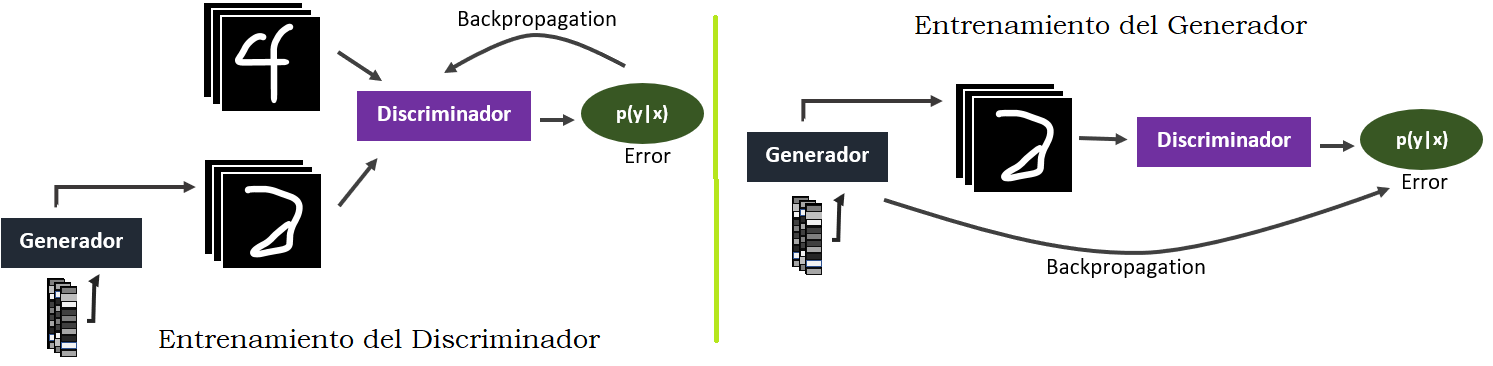

In [ ]:
EPOCHS = 51  # Número de épocas

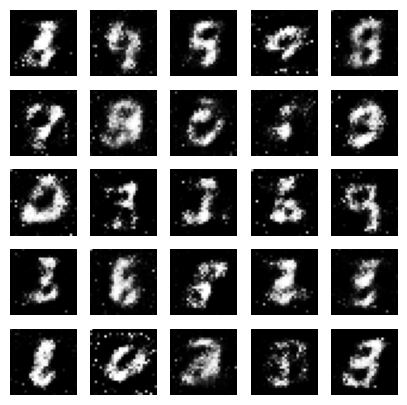

In [ ]:
# training mode
generator.train()
discriminator.train()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------" )
    for batch, (real_images, _) in enumerate(train_dataloader):
        ## ---------------------- Entrenamiento del Discriminador ----------------------
        discriminator_opt.zero_grad()
        cur_batch_size = len(real_images) # Tamaño "real" del batch
        real_images = real_images.to(device)
        # Generar imágenes falsas
        noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
        fake_images = generator(noise)
        # Predicción en imágenes reales
        real_preds = discriminator(real_images)
        # Predicción en imágenes falsas
        fake_preds = discriminator(fake_images.detach())
        # Se calcula la función de costo del discriminador
        disc_loss = discriminator_loss(real_preds, fake_preds)
        # Backpropagation para actualizar parámetros del discriminador
        disc_loss.backward()
        discriminator_opt.step()

        ## ---------------------- Entrenamiento del Generador ----------------------
        # Generar imágenes falsas
        noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
        generated_images = generator(noise)
        generator_opt.zero_grad()
        # Predicción en imágenes falsas
        fake_preds = discriminator(generated_images)
        # Se calcula la función de costo del generador
        gen_loss = generator_loss(fake_preds)
        # Backpropagation para actualizar parámetros del generador
        gen_loss.backward()
        generator_opt.step()

        # Visualizar progreso del entrenamiento
        if batch % 300 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tG-Loss: {:.6f} D-Loss: {:.6f}'.format(
                epoch, batch * len(real_images), len(train_dataloader.dataset),
                100. * batch / len(train_dataloader), gen_loss.item(), disc_loss.item()))


    # Visualizar imágenes generadas cada cierto tiempo
    if epoch%5 ==0:
        display.clear_output(wait=True)
        test_imgs = generator(noise_test).cpu().detach()
        show_grid(test_imgs,epoch)


In [ ]:
# Crear GIF con imágenes generadas
images = list()
filenames = glob.glob('./image*.png')
filenames = sorted(filenames)
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./vainilla_gan.gif', images) # Guardar GIF

<ipython-input-39-c24a07804133>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
